In [50]:
!pip install tqdm

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [51]:
from tqdm.auto import tqdm

In [20]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


# Data preparation

Check if the missing values are presented in the features.
If there are missing values:
For caterogiral features, replace them with 'NA'
For numerical features, replace with with 0.0
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [21]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [22]:
categorical = df.dtypes[df.dtypes == object].index.tolist()
categorical

['lead_source', 'industry', 'employment_status', 'location']

In [23]:
numerical = list(set(df.columns) - set(categorical))
print(numerical)
numerical.remove("converted")
print(numerical)

['lead_score', 'interaction_count', 'number_of_courses_viewed', 'annual_income', 'converted']
['lead_score', 'interaction_count', 'number_of_courses_viewed', 'annual_income']


In [24]:
df[numerical] = df[numerical].fillna(0)
df[categorical] = df[categorical].fillna("NaN")
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [25]:
full_train_df,test_df = train_test_split(df,test_size=0.2,random_state=1)
train_df,val_df = train_test_split(full_train_df,test_size=0.25,random_state=1)
len(full_train_df),len(train_df),len(test_df),len(val_df)

(1169, 876, 293, 293)

In [26]:
train_df.reset_index(drop=True, inplace = True)
val_df.reset_index(drop=True, inplace = True)
test_df.reset_index(drop=True, inplace = True)
full_train_df.reset_index(drop=True,inplace=True)

# Question 1: ROC AUC feature importance

In [27]:
results_neg = {}
results = {}
for col in numerical:
    auc = roc_auc_score(train_df.converted, train_df[col])
    results_neg[col] = {'auc': auc}
    if auc < 0.5:
        auc = roc_auc_score(train_df.converted, -train_df[col])
    print(f"{col}: AUC = {auc:.3f}")
    results[col] = {'auc': auc}

print(results_neg)
print(results)

max_key = max(results, key=lambda k: results[k]['auc'])
print(f"feature: {max_key}")
print(f"Max auc : {results[max_key]['auc']}")

lead_score: AUC = 0.614
interaction_count: AUC = 0.738
number_of_courses_viewed: AUC = 0.764
annual_income: AUC = 0.552
{'lead_score': {'auc': 0.6144993577250176}, 'interaction_count': {'auc': 0.738270176293409}, 'number_of_courses_viewed': {'auc': 0.7635680590007088}, 'annual_income': {'auc': 0.5519578313253012}}
{'lead_score': {'auc': 0.6144993577250176}, 'interaction_count': {'auc': 0.738270176293409}, 'number_of_courses_viewed': {'auc': 0.7635680590007088}, 'annual_income': {'auc': 0.5519578313253012}}
feature: number_of_courses_viewed
Max auc : 0.7635680590007088


# Question 2: Training the model

In [30]:
def train(df_train,y_train,C = 1.0):
    
    dicts = df_train[categorical + numerical].to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

    model.fit(X_train,y_train)

    return dv,model

In [31]:
def predict(df_val,dv,model):
    
    dicts_val = df_val[categorical + numerical].to_dict(orient = 'records')
    X_val = dv.transform(dicts_val)
    y_pred = model.predict_proba(X_val)[:,1]

    return y_pred

In [32]:
dv,model = train(train_df,train_df.converted.values)

In [33]:
y_pred = predict(val_df,dv,model)

In [34]:
roc_score = roc_auc_score(val_df.converted,y_pred)
round(roc_score,3)

0.817

# Question 3: Precision and Recall

In [36]:
def precision_recall_df(y_val,y_pred):
    thresholds = np.linspace(0,1,101)
    scores = []
    for t in thresholds:
        actual_positive = y_val == 1
        actual_negative = y_val == 0
        positive_class = y_pred >= t
        negative_class = y_pred < t
        
        tp = (actual_positive & positive_class).sum()
        tn = (actual_negative & negative_class).sum()
        fp = (actual_negative & positive_class).sum()
        fn = (actual_positive & negative_class).sum()
    
        scores.append((t,tp,tn,fn,fp))
        
    columns = ["thresholds","tp","tn","fn","fp"]
    df_scores = pd.DataFrame(scores,columns = columns)
    df_scores["recall"] = df_scores.tp/(df_scores.tp + df_scores.fn)
    df_scores["precision"] = df_scores.tp/(df_scores.fp + df_scores.tp)
    return df_scores

In [37]:
df_scores = precision_recall_df(val_df.converted.values,y_pred)
df_scores

,thresholds,tp,tn,fn,fp,recall,precision
0,0.00,171,0,0,122,1.000000,0.583618
1,0.01,171,0,0,122,1.000000,0.583618
2,0.02,171,0,0,122,1.000000,0.583618
3,0.03,171,0,0,122,1.000000,0.583618
4,0.04,171,0,0,122,1.000000,0.583618
...,...,...,...,...,...,...,...
96,0.96,3,122,168,0,0.017544,1.000000
97,0.97,1,122,170,0,0.005848,1.000000
98,0.98,0,122,171,0,0.000000,NaN
99,0.99,0,122,171,0,0.000000,NaN


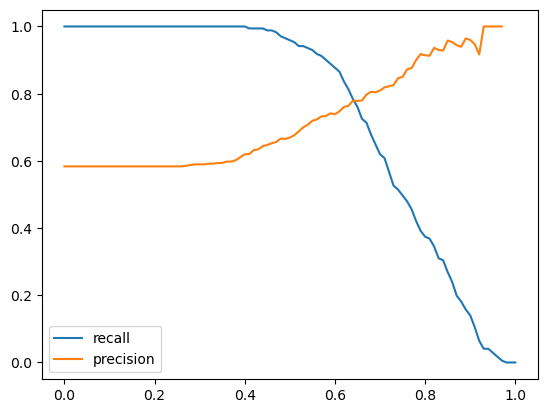

In [38]:
plt.plot(df_scores.thresholds,df_scores["recall"],label = 'recall')
plt.plot(df_scores.thresholds,df_scores["precision"],label = 'precision')
plt.legend()

In [39]:
df_scores["diff"] =  np.abs(df_scores["precision"] - df_scores["recall"])
df_scores

,thresholds,tp,tn,fn,fp,recall,precision,diff
0,0.00,171,0,0,122,1.000000,0.583618,0.416382
1,0.01,171,0,0,122,1.000000,0.583618,0.416382
2,0.02,171,0,0,122,1.000000,0.583618,0.416382
3,0.03,171,0,0,122,1.000000,0.583618,0.416382
4,0.04,171,0,0,122,1.000000,0.583618,0.416382
...,...,...,...,...,...,...,...,...
96,0.96,3,122,168,0,0.017544,1.000000,0.982456
97,0.97,1,122,170,0,0.005848,1.000000,0.994152
98,0.98,0,122,171,0,0.000000,NaN,NaN
99,0.99,0,122,171,0,0.000000,NaN,NaN


In [40]:
idx = np.argmin(df_scores["diff"])
idx

np.int64(64)

In [41]:
best_threshold = df_scores.loc[idx,'thresholds']

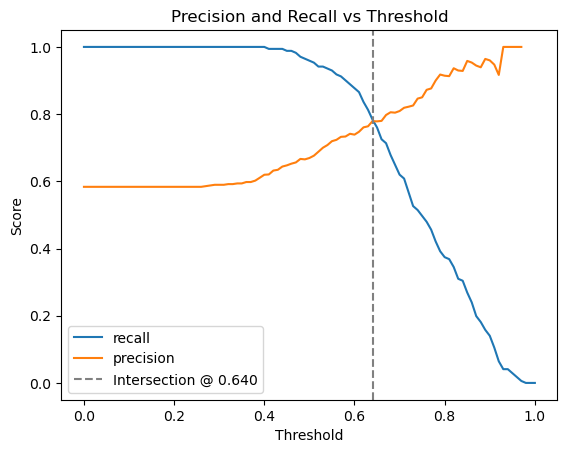

In [42]:
plt.plot(df_scores.thresholds,df_scores["recall"],label = 'recall')
plt.plot(df_scores.thresholds,df_scores["precision"],label = 'precision')
plt.axvline(best_threshold, color='gray', linestyle='--', label=f'Intersection @ {best_threshold:.3f}')
plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.show()

# Question 4: F1 score

In [44]:
df_scores["F1_score"] = 2 * (df_scores.precision * df_scores.recall)/(df_scores.precision + df_scores.recall)
df_scores

,thresholds,tp,tn,fn,fp,recall,precision,diff,F1_score
0,0.00,171,0,0,122,1.000000,0.583618,0.416382,0.737069
1,0.01,171,0,0,122,1.000000,0.583618,0.416382,0.737069
2,0.02,171,0,0,122,1.000000,0.583618,0.416382,0.737069
3,0.03,171,0,0,122,1.000000,0.583618,0.416382,0.737069
4,0.04,171,0,0,122,1.000000,0.583618,0.416382,0.737069
...,...,...,...,...,...,...,...,...,...
96,0.96,3,122,168,0,0.017544,1.000000,0.982456,0.034483
97,0.97,1,122,170,0,0.005848,1.000000,0.994152,0.011628
98,0.98,0,122,171,0,0.000000,NaN,NaN,NaN
99,0.99,0,122,171,0,0.000000,NaN,NaN,NaN


In [45]:
idx_max = np.argmax(df_scores["F1_score"])
idx_max

np.int64(57)

In [46]:
df_scores.loc[idx_max]

thresholds      0.570000
tp            156.000000
tn             65.000000
fn             15.000000
fp             57.000000
recall          0.912281
precision       0.732394
diff            0.179886
F1_score        0.812500
Name: 57, dtype: float64

In [47]:
F1_max_threshold = df_scores.loc[idx_max,'thresholds']
F1_max_threshold

np.float64(0.5700000000000001)

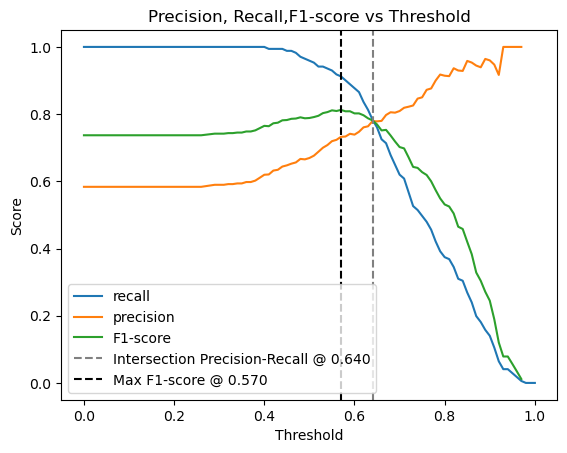

In [48]:
plt.plot(df_scores.thresholds,df_scores["recall"],label = 'recall')
plt.plot(df_scores.thresholds,df_scores["precision"],label = 'precision')
plt.plot(df_scores.thresholds,df_scores["F1_score"],label = 'F1-score')

plt.axvline(best_threshold, color='gray', linestyle='--', label=f'Intersection Precision-Recall @ {best_threshold:.3f}')
plt.axvline(F1_max_threshold, color='black', linestyle='--', label=f'Max F1-score @ {F1_max_threshold:.3f}')

plt.legend()
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall,F1-score vs Threshold')
plt.show()

# Question 5: 5-Fold CV

In [52]:
scores = []
n_splits = 5
kfold = KFold(n_splits = n_splits, shuffle=True,random_state=1)
for train_idx,val_idx in tqdm(kfold.split(full_train_df),total = n_splits):
        
    df_train = full_train_df.iloc[train_idx]
    df_val = full_train_df.iloc[val_idx]
    
    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    dv,model = train(df_train,y_train,C=1)
    y_pred = predict(df_val,dv,model)
    
    auc = roc_auc_score(y_val,y_pred)
    scores.append(auc)

    print('%.3f +- %.3f' % (np.mean(scores),np.std(scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

0.806 +- 0.000
0.839 +- 0.033
0.818 +- 0.040
0.814 +- 0.035
0.822 +- 0.036


# Question 6: Hyperparameter Tuning

In [53]:
results = {}
kfold = KFold(n_splits = n_splits, shuffle=True,random_state=1)

for C in [0.000001, 0.001, 1]:
    scores = []
    n_splits = 5
    for train_idx,val_idx in tqdm(kfold.split(full_train_df),total = n_splits):
            
        df_train = full_train_df.iloc[train_idx]
        df_val = full_train_df.iloc[val_idx]
        
        y_train = df_train.converted.values
        y_val = df_val.converted.values
        
        dv,model = train(df_train,y_train,C=C)
        y_pred = predict(df_val,dv,model)
        
        auc = roc_auc_score(y_val,y_pred)
        scores.append(auc)

    print('%.3f +- %.3f' % (np.mean(scores),np.std(scores)))
    results[C] = round(np.mean(scores),3),round(np.std(scores),3)

results

  0%|          | 0/5 [00:00<?, ?it/s]

0.560 +- 0.024


  0%|          | 0/5 [00:00<?, ?it/s]

0.867 +- 0.029


  0%|          | 0/5 [00:00<?, ?it/s]

0.822 +- 0.036


{1e-06: (np.float64(0.56), np.float64(0.024)),
 0.001: (np.float64(0.867), np.float64(0.029)),
 1: (np.float64(0.822), np.float64(0.036))}